# Import libraries

In [1]:
import os
import time
import pickle
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from pymongo import MongoClient

from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OrdinalEncoder, StandardScaler
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, make_scorer
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier

# Prepare data

## Start MongoDB with data previously dumped

In [2]:
data_path = os.path.abspath("../datasets/processed/yelp_mongo_dumping.json")
!docker stop mongo
!docker run \
    -v mongodbdata:/data/db \
    -v {data_path}:/data/yelp_mongo_dumping.json \
    -p 27017:27017 \
    --rm -it -d --name mongo mongo

mongo
0104cd536115dd4356feab224ee9a57779af192b9253c49f2400a1a17c8fbbe8


## Load data from MongoDB

In [3]:
client = MongoClient("mongodb://localhost:27017")
collection = client.cmp1044.yelp_reviews

data = pd.DataFrame(collection.aggregate([
    {"$project": {
        "_id": 0,
        "dataset": 1, 
        "label": 1, 
        "rating": 1, 
        "content_text": 1,
        "content_emotion": 1, 
        "content_polarity": 1, 
        "content_subjectivity": 1, 
        "content_wordcount": {"$size": "$content_words"}}
    },
]))

data.head()

,dataset,rating,label,content_text,content_polarity,content_subjectivity,content_emotion,content_wordcount
0,yelpchi,3,organic,The only place inside the Loop that you can st...,-0.047,0.625,neutral,53
1,yelpchi,3,organic,"This place is disgusting, absolutely horrible,...",-0.435,0.505,disgust,49
2,yelpchi,1,organic,Disgusting!!! There is literally duct tape hol...,-0.265,0.557,disgust,82
3,yelpchi,5,organic,Let me begin by saying that there are two kind...,0.025,0.570,neutral,412
4,yelpchi,2,organic,"Good location, really run down. I am surprised...",0.211,0.497,surprise,15


## Select features and split data
- Encode discrete features
- Standardize continuous features

In [4]:
discrete_features = ["rating", "content_emotion"]
continuous_features = ["content_polarity", "content_subjectivity", "content_wordcount"] 


def create_balanced_data(data, random_state=42):
    fraud = data[data["label"]=="fraud"]
    organic = data[data["label"]=="organic"]
    n = min(fraud.shape[0], organic.shape[0])
    fraud = fraud.sample(n, random_state=random_state)
    organic = organic.sample(n, random_state=random_state)
    return pd.concat([fraud, organic], ignore_index=True)
    

def get_train_test_data(data, discrete_features, continuous_features, target="label"):
    X, y = data[discrete_features + continuous_features], data[target]
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
    ct = ColumnTransformer([
         ("encode", OrdinalEncoder(), discrete_features),
         ("standardize", StandardScaler(), continuous_features)
    ])
    X_train, X_test = ct.fit_transform(X_train), ct.fit_transform(X_test)
    return X_train, X_test, y_train, y_test

train_test_data = {
    "yelpchi": get_train_test_data(data[data.dataset=='yelpchi'], discrete_features, continuous_features, 'label'),
    "yelpnyc": get_train_test_data(data[data.dataset=='yelpnyc'], discrete_features, continuous_features, 'label'),
    "yelpchi_balanced": get_train_test_data(
        create_balanced_data(data[data.dataset=='yelpchi']), discrete_features, continuous_features, 'label',
    ),
    "yelpnyc_balanced": get_train_test_data(
        create_balanced_data(data[data.dataset=='yelpnyc']), discrete_features, continuous_features, 'label',
    ),
}

print("Shape of X_train, X_test, y_train, y_test:")
for k, v in train_test_data.items():
    print("{}:".format(k), list(map(lambda it: it.shape, v)))

Shape of X_train, X_test, y_train, y_test:
yelpchi: [(47168, 5), (20216, 5), (47168,), (20216,)]
yelpnyc: [(251265, 5), (107686, 5), (251265,), (107686,)]
yelpchi_balanced: [(12485, 5), (5351, 5), (12485,), (5351,)]
yelpnyc_balanced: [(51604, 5), (22116, 5), (51604,), (22116,)]


# Train/test base models
- Decision Tree Classifier
- Random Forest Classifer
- Support Vector Machine Classifier

In [5]:
scores = {}

for ds_name, data in train_test_data.items():
    dt = DecisionTreeClassifier()
    rf = RandomForestClassifier()
    ada = AdaBoostClassifier()
    gb = GradientBoostingClassifier()
    
    models = [dt, rf, ada, gb]
    scores[ds_name] = {}
    for model in models:
        model_name = model.__class__.__name__.lower().replace("classifier", "")
        scores[ds_name][model_name] = {}
        X_train, X_test, y_train, y_test = data
        start_time = time.time()
        print("Training {} on {}...".format(model_name.upper(), ds_name.upper()))
        model.fit(X_train, y_train)
        print("Done! Took {}s".format(round(time.time() - start_time, 1)))
        y_pred = model.predict(X_test)
        scores[ds_name][model_name]["accuracy"] = accuracy_score(y_test, y_pred)
        scores[ds_name][model_name]["precision"] = precision_score(
            y_test, y_pred, average="binary", pos_label="fraud", zero_division=0,
        )
        scores[ds_name][model_name]["recall"] = recall_score(
            y_test, y_pred, average="binary", pos_label="fraud", zero_division=0,
        )
        scores[ds_name][model_name]["f1"] = f1_score(
            y_test, y_pred, average="binary", pos_label="fraud", zero_division=0,
        )
        print(scores[ds_name][model_name])
        print("-" * 100)
    print("=" * 100)
    print()

Training DECISIONTREE on YELPCHI...
Done! Took 0.3s
{'accuracy': 0.7735951721408785, 'precision': 0.1829145728643216, 'recall': 0.20342771982116245, 'f1': 0.19262656553183985}
----------------------------------------------------------------------------------------------------
Training RANDOMFOREST on YELPCHI...
Done! Took 5.5s
{'accuracy': 0.8565492679066087, 'precision': 0.2923076923076923, 'recall': 0.05663189269746647, 'f1': 0.09488139825218476}
----------------------------------------------------------------------------------------------------
Training ADABOOST on YELPCHI...
Done! Took 7.6s
{'accuracy': 0.865799366838148, 'precision': 0.4013605442176871, 'recall': 0.021982116244411327, 'f1': 0.04168138466972801}
----------------------------------------------------------------------------------------------------
Training GRADIENTBOOSTING on YELPCHI...
Done! Took 3.0s
{'accuracy': 0.8660466956865849, 'precision': 0.38235294117647056, 'recall': 0.014530551415797318, 'f1': 0.0279971284

## Plot testing result

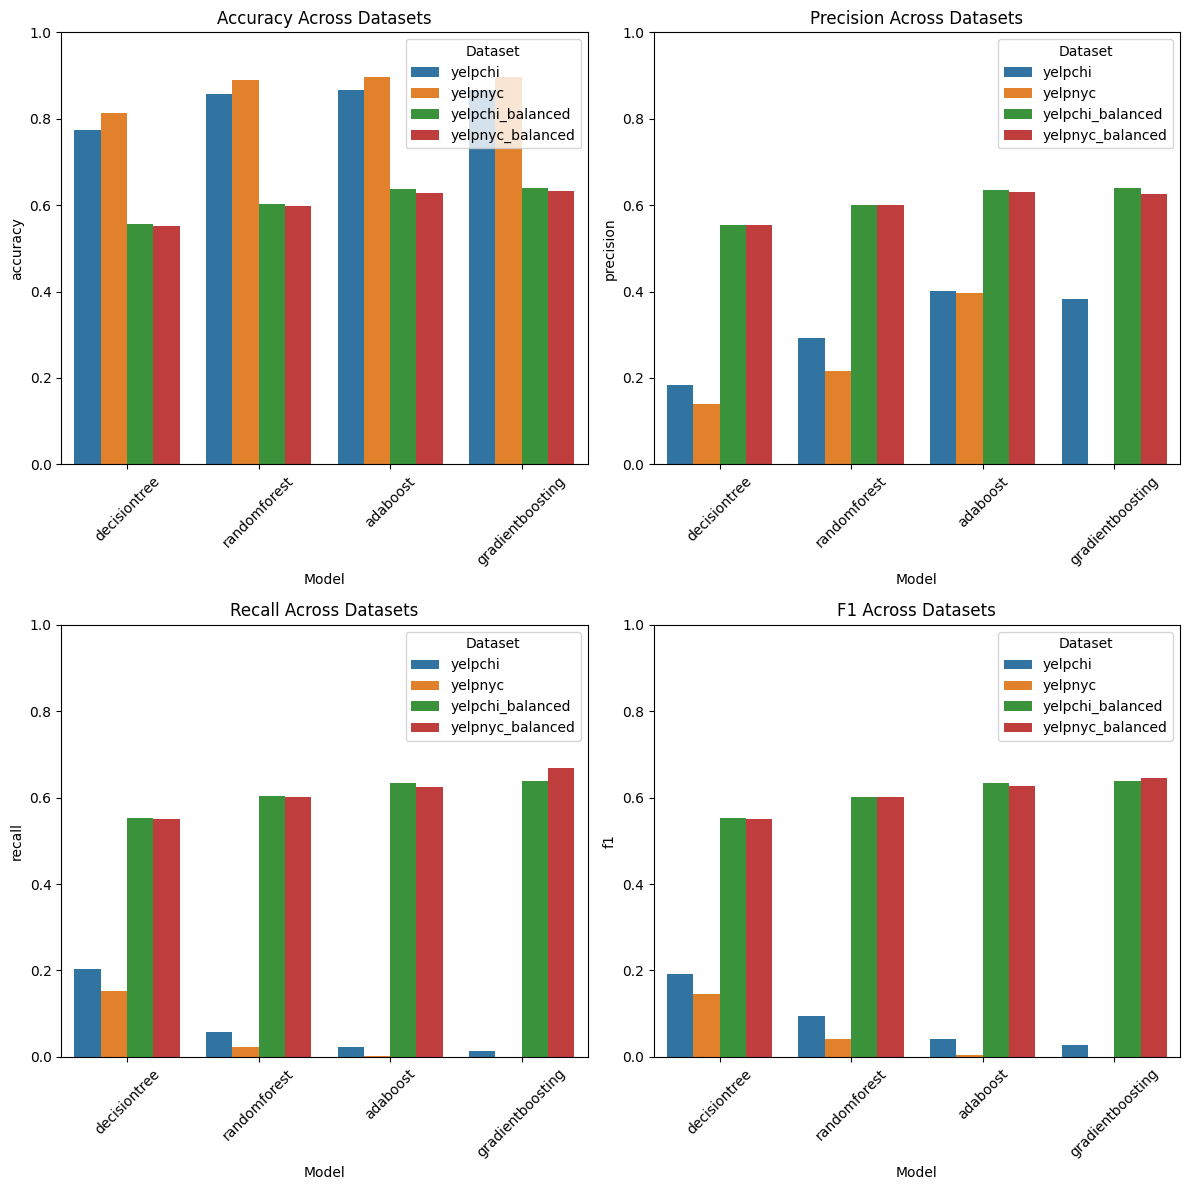

In [6]:
def create_result_df(result_dict, metric):
    data = {'Dataset': [], 'Model': [], metric: []}
    
    for dataset, models in result_dict.items():
        for model, scores in models.items():
            data['Dataset'].append(dataset)
            data['Model'].append(model)
            data[metric].append(scores[metric])
    
    return pd.DataFrame(data)


def plot_results(result_dict):
    metrics = ['accuracy', 'precision', 'recall', 'f1']
    
    fig, axes = plt.subplots(2, 2, figsize=(12, 12))
    for i, metric in enumerate(metrics):
        row, col = divmod(i, 2)
        df = create_result_df(result_dict, metric)
        
        sns.barplot(x='Model', y=metric, hue='Dataset', data=df, ax=axes[row, col])
        axes[row, col].set_title(f'{metric.capitalize()} Across Datasets')
        axes[row, col].set_ylim(0, 1)
        axes[row, col].set_xticks(axes[row, col].get_xticks())
        axes[row, col].set_xticklabels(labels=axes[row, col].get_xticklabels(), rotation=45)    
    
    plt.tight_layout()
    plt.show()


plot_results(scores)

# Hyperparameter tuning

## Define tuning grid for base models

In [7]:
dt_grid = {"max_depth": [2, 4, 6, 8, 10], "criterion": ["gini", "entropy"]}
rf_grid = {"max_depth": [3, 5, 10], "n_estimators": [10, 50, 100]}
ada_grid = {'n_estimators': [50, 100, 200], 'learning_rate': [0.1, 0.5, 1]}
gb_grid = {'n_estimators': [100, 200, 500], 'max_depth': [3, 5, 10]}

## Tune base models by GridSearchCV

In [8]:
tuned_model_files = []
f1_scorer = make_scorer(f1_score, greater_is_better=True, average="binary", pos_label="fraud", zero_division=0)

for ds_name, data in train_test_data.items():
    dt_gs = GridSearchCV(
        DecisionTreeClassifier(), 
        dt_grid, 
        scoring = f1_scorer,
        n_jobs = 10,
        cv = 5,
        verbose=2
    )
    rf_gs = GridSearchCV(
        RandomForestClassifier(), 
        rf_grid, 
        scoring = f1_scorer,
        n_jobs = 10,
        cv = 5,
        verbose=2,
    )
    ada_gs = GridSearchCV(
        AdaBoostClassifier(), 
        ada_grid, 
        scoring = f1_scorer,
        n_jobs = 10,
        cv = 5,
        verbose=2,
    ) 
    gb_gs = GridSearchCV(
        GradientBoostingClassifier(), 
        gb_grid, 
        scoring = f1_scorer,
        n_jobs = 10,
        cv = 5,
        verbose=2,
    ) 
    models = [dt_gs, rf_gs, ada_gs, gb_gs]
    X_train, X_test, y_train, y_test = data
    for model in models:
        start_time = time.time()
        print("Tuning {} on {}...".format(model.estimator.__class__.__name__.upper(), ds_name.upper()))
        model.fit(X_train, y_train)
        print("Done! Took {}s".format(round(time.time() - start_time, 1)))
        print("Best params for {} on {}: {}".format(model.estimator.__class__.__name__.upper(), ds_name.upper(), model.best_params_))
        print()
        
        model_name = model.estimator.__class__.__name__.lower().replace("classifier", "")
        file_path = f"../models/{model_name}_{ds_name}_gs_best.pkl"
        with open(file_path, "wb") as f:
            pickle.dump(model, f)
        tuned_model_files.append(file_path)
        
    print("=" * 100)

Tuning DECISIONTREECLASSIFIER on YELPCHI...
Fitting 5 folds for each of 10 candidates, totalling 50 fits
Done! Took 5.4s
Best params for DECISIONTREECLASSIFIER on YELPCHI: {'criterion': 'gini', 'max_depth': 10}

Tuning RANDOMFORESTCLASSIFIER on YELPCHI...
Fitting 5 folds for each of 9 candidates, totalling 45 fits
Done! Took 11.3s
Best params for RANDOMFORESTCLASSIFIER on YELPCHI: {'max_depth': 10, 'n_estimators': 50}

Tuning ADABOOSTCLASSIFIER on YELPCHI...
Fitting 5 folds for each of 9 candidates, totalling 45 fits
Done! Took 76.7s
Best params for ADABOOSTCLASSIFIER on YELPCHI: {'learning_rate': 1, 'n_estimators': 50}

Tuning GRADIENTBOOSTINGCLASSIFIER on YELPCHI...
Fitting 5 folds for each of 9 candidates, totalling 45 fits
Done! Took 216.6s
Best params for GRADIENTBOOSTINGCLASSIFIER on YELPCHI: {'max_depth': 10, 'n_estimators': 500}

Tuning DECISIONTREECLASSIFIER on YELPNYC...
Fitting 5 folds for each of 10 candidates, totalling 50 fits
Done! Took 26.5s
Best params for DECISIONTREE

## Plot best results after tuning

{'accuracy': 0.8578353779184804, 'precision': 0.296137339055794, 'recall': 0.05141579731743666, 'f1': 0.08761904761904761, 'feature_importances': [0.1903257853084939, 0.08113867800746986, 0.22799375317572013, 0.1838283460738481, 0.31671343743446806]}
----------------------------------------------------------------------------------------------------
{'accuracy': 0.8665908191531461, 'precision': 0.43010752688172044, 'recall': 0.014903129657228018, 'f1': 0.028808066258552395, 'feature_importances': [0.17094764714514954, 0.0835918842952305, 0.23521722619715796, 0.1924972082176138, 0.3177460341448482]}
----------------------------------------------------------------------------------------------------
{'accuracy': 0.865799366838148, 'precision': 0.4013605442176871, 'recall': 0.021982116244411327, 'f1': 0.04168138466972801, 'feature_importances': [0.14, 0.06, 0.16, 0.12, 0.52]}
----------------------------------------------------------------------------------------------------
{'accuracy': 

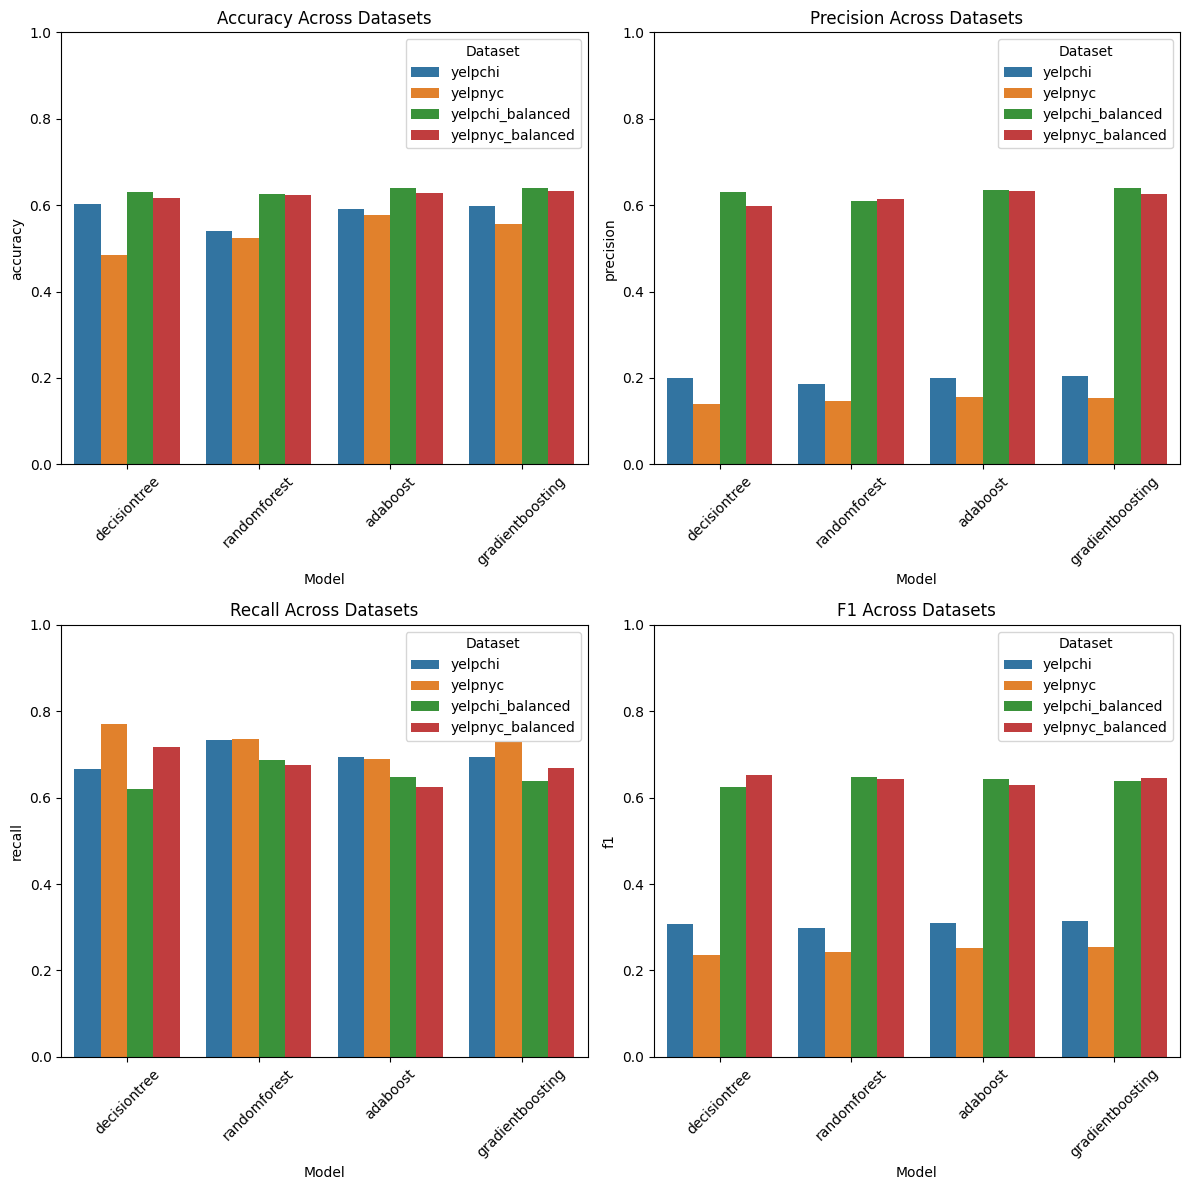

In [9]:
scores = {}

for ds_name, data in train_test_data.items():
    scores[ds_name] = {}
    models = []
    for file in tuned_model_files:
        if ds_name not in file:
            continue
        with open(file, "rb") as f:
            models.append(pickle.load(f))
    _, X_test, _, y_test = data
    for model in models:
        model_name = model.estimator.__class__.__name__.lower().replace("classifier", "")
        scores[ds_name][model_name] = {}
        y_pred = model.predict(X_test)
        scores[ds_name][model_name]["accuracy"] = accuracy_score(y_test, y_pred)
        scores[ds_name][model_name]["precision"] = precision_score(
            y_test, y_pred, average="binary", pos_label="fraud", zero_division=0,
        )
        scores[ds_name][model_name]["recall"] = recall_score(
            y_test, y_pred, average="binary", pos_label="fraud", zero_division=0,
        )
        scores[ds_name][model_name]["f1"] = f1_score(
            y_test, y_pred, average="binary", pos_label="fraud", zero_division=0,
        )
        scores[ds_name][model_name]["feature_importances"] = model.best_estimator_.feature_importances_.tolist()
        print(scores[ds_name][model_name])
        print("-" * 100)
    print("=" * 100)
    print()


plot_results(scores)

## Plot feature importances by different estimators

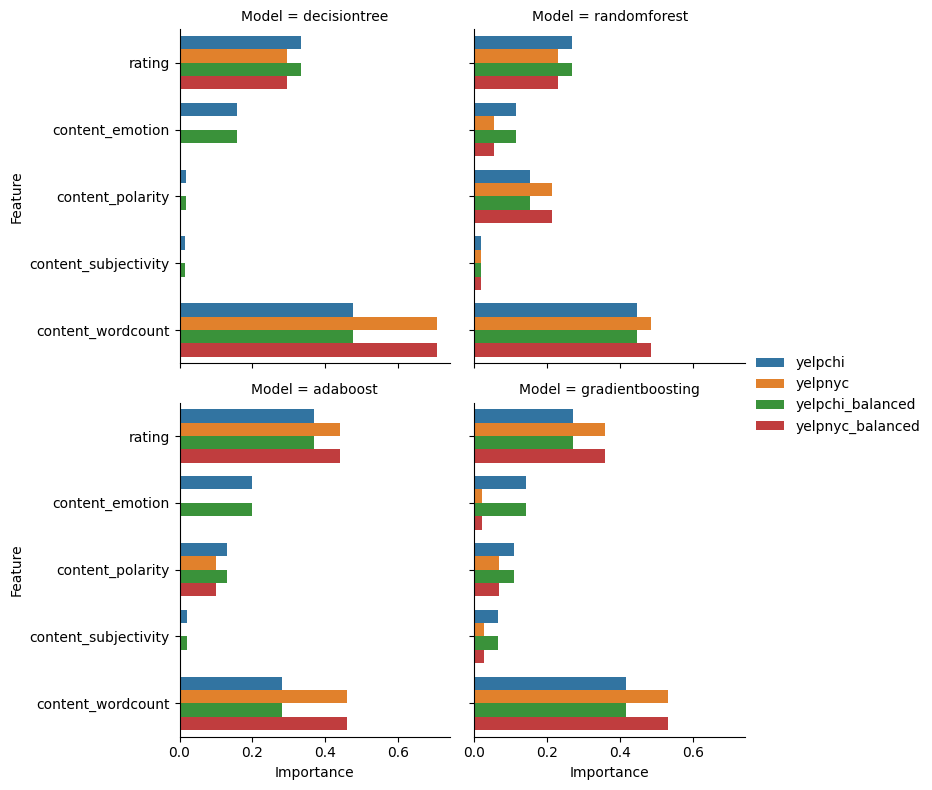

In [10]:
def plot_feature_importances(result_dict, feature_names):
    df_list = []
    
    for dataset, models in result_dict.items():
        for model, metrics in models.items():
            feature_importances = metrics['feature_importances']
            df_list.append(pd.DataFrame({'Feature': feature_names,
                                         'Importance': feature_importances,
                                         'Model': model,
                                         'Dataset': dataset}))
    
    df = pd.concat(df_list)
    
    g = sns.FacetGrid(df, col="Model", col_wrap=2, height=4)
    g.map_dataframe(sns.barplot, x='Importance', y='Feature', hue='Dataset', palette='tab10')
    g.set_titles(size=10)
    g.set_axis_labels("Importance", "Feature", size=10)
    g.add_legend()
    
    plt.show()


plot_feature_importances(scores, discrete_features + continuous_features)